# Filtering a Time Series with Convolutional Neural Network

#### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
# Data manipulation
import datetime
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Scalation
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

# Warnings
import warnings

In [2]:
from tensorflow.keras.optimizers.legacy import Adam

In [3]:
warnings.filterwarnings('ignore')

##### Visualization Set Up

In [4]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = True

In [5]:
print(tf.__version__)

2.15.0


In [6]:
# Numerical & Tensorflow Setting Seeds
tf.random.set_seed(42)
np.random.seed(42)

#### Loading Data

In [7]:
train_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/train.csv', index_col=0)
val_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/val.csv', index_col=0)
test_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


##### Setting Data Window Function

In [8]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

##### Setting Compile & Fit Function

In [11]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [12]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

### Convolutional Neural Networks (CNN)

#### Single-Step Model

In [15]:
# Values obtained from chapter 15

mae_val = [0.083, 0.068, 0.033, 0.03]
mae_test = [0.081, 0.068, 0.029, 0.026]

In [16]:
# Kernel "filter" width
KERNEL_WIDTH = 3
# Predictions on 24 hours period
LABEL_WIDTH = 24
# Input length equation
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

##### Convolutional Windows

In [17]:
# Setting Convolutional Windows
conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['traffic_volume'])

In [18]:
# Convolutional Model Set-Up
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

# Model Training
history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 0s 676us/step - loss: 0.0226 - mean_absolute_error: 0.0969 - val_loss: 0.0059 - val_mean_absolute_error: 0.0560
Epoch 2/50
384/384 [==============================] - 0s 613us/step - loss: 0.0055 - mean_absolute_error: 0.0545 - val_loss: 0.0043 - val_mean_absolute_error: 0.0491
Epoch 3/50
384/384 [==============================] - 0s 591us/step - loss: 0.0041 - mean_absolute_error: 0.0465 - val_loss: 0.0034 - val_mean_absolute_error: 0.0429
Epoch 4/50
384/384 [==============================] - 0s 597us/step - loss: 0.0035 - mean_absolute_error: 0.0430 - val_loss: 0.0031 - val_mean_absolute_error: 0.0409
Epoch 5/50
384/384 [==============================] - 0s 531us/step - loss: 0.0031 - mean_absolute_error: 0.0400 - val_loss: 0.0029 - val_mean_absolute_error: 0.0403
Epoch 6/50
384/384 [==============================] - 0s 538us/step - loss: 0.0029 - mean_absolute_error: 0.0386 - val_loss: 0.0023 - val_mean_absolute_error: 0.0357
Epoc

##### Model Performance Visualization

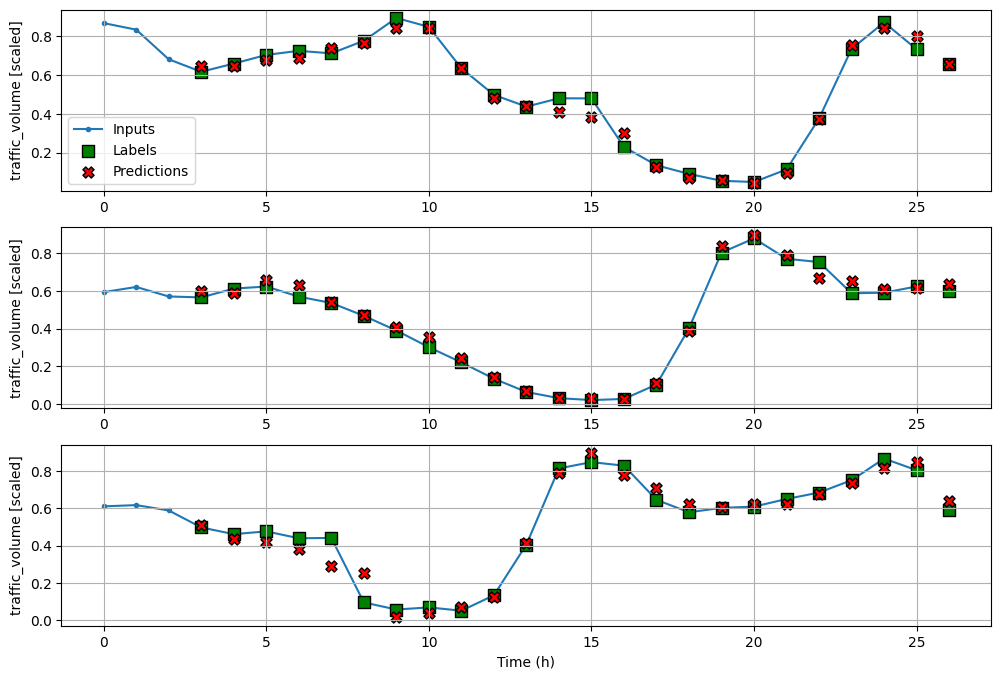

In [19]:
wide_conv_window.plot(cnn_model)

#### Combining The Convolutional Neural Network with Long Short-Term Model

In [20]:
# Convolutional & LSTM Model Set-Up
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

# Model Training
history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0340 - mean_absolute_error: 0.1209 - val_loss: 0.0063 - val_mean_absolute_error: 0.0588
Epoch 2/50
384/384 [==============================] - 0s 828us/step - loss: 0.0056 - mean_absolute_error: 0.0551 - val_loss: 0.0047 - val_mean_absolute_error: 0.0515
Epoch 3/50
384/384 [==============================] - 0s 820us/step - loss: 0.0045 - mean_absolute_error: 0.0500 - val_loss: 0.0036 - val_mean_absolute_error: 0.0451
Epoch 4/50
384/384 [==============================] - 0s 900us/step - loss: 0.0039 - mean_absolute_error: 0.0462 - val_loss: 0.0032 - val_mean_absolute_error: 0.0426
Epoch 5/50
384/384 [==============================] - 0s 914us/step - loss: 0.0034 - mean_absolute_error: 0.0428 - val_loss: 0.0033 - val_mean_absolute_error: 0.0425
Epoch 6/50
384/384 [==============================] - 0s 869us/step - loss: 0.0032 - mean_absolute_error: 0.0409 - val_loss: 0.0032 - val_mean_absolute_error: 0.0435
Epoch 

##### Comparing Model Performance with Past Models

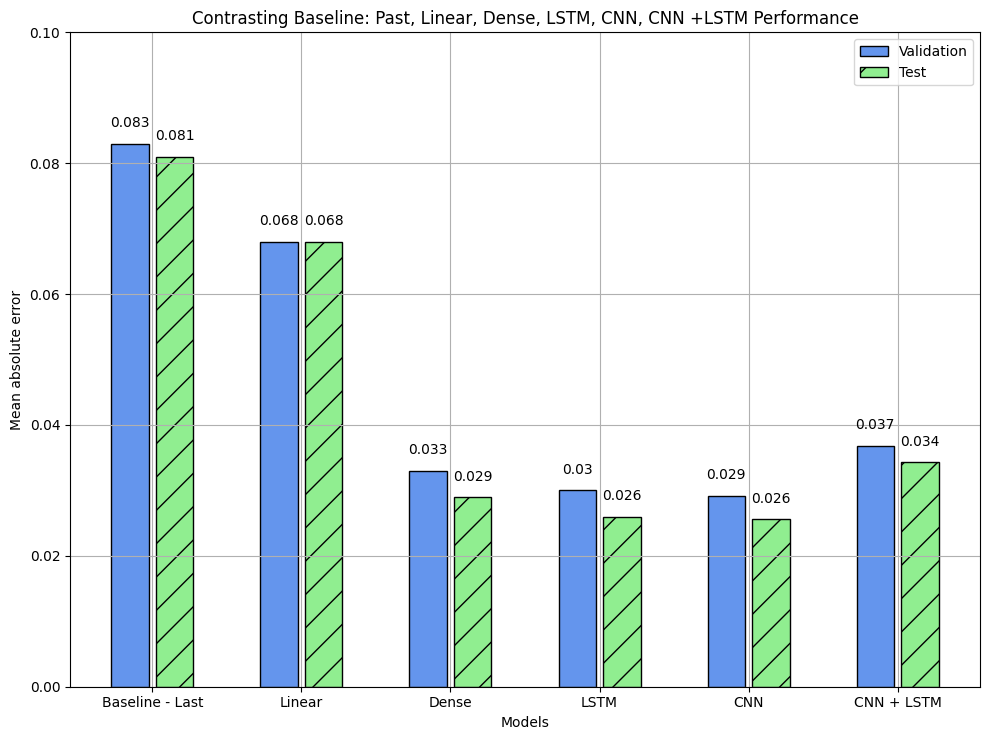

In [21]:
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='cornflowerblue', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='lightgreen', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.title('Contrasting Baseline: Past, Linear, Dense, LSTM, CNN, CNN +LSTM Performance')
plt.tight_layout()
plt.show()

#### Convolutional Neural Network as a Multi-Step Model

In [22]:
# Values obtained from chapter 15

ms_mae_val = [0.352, 0.347, 0.088, 0.078, 0.070]
ms_mae_test = [0.347, 0.341, 0.076, 0.064, 0.058]

In [24]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

# Multi-Step Window
multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['traffic_volume'])

In [25]:
# Convolutional Model on Multi-step Set-Up
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

# Model Training
history = compile_and_fit(ms_cnn_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 0s 923us/step - loss: 0.0345 - mean_absolute_error: 0.1225 - val_loss: 0.0167 - val_mean_absolute_error: 0.0848
Epoch 2/50
383/383 [==============================] - 0s 799us/step - loss: 0.0143 - mean_absolute_error: 0.0792 - val_loss: 0.0164 - val_mean_absolute_error: 0.0843
Epoch 3/50
383/383 [==============================] - 0s 791us/step - loss: 0.0141 - mean_absolute_error: 0.0786 - val_loss: 0.0165 - val_mean_absolute_error: 0.0875
Epoch 4/50
383/383 [==============================] - 0s 787us/step - loss: 0.0139 - mean_absolute_error: 0.0782 - val_loss: 0.0159 - val_mean_absolute_error: 0.0823
Epoch 5/50
383/383 [==============================] - 0s 892us/step - loss: 0.0138 - mean_absolute_error: 0.0782 - val_loss: 0.0158 - val_mean_absolute_error: 0.0839
Epoch 6/50
383/383 [==============================] - 0s 889us/step - loss: 0.0137 - mean_absolute_error: 0.0777 - val_loss: 0.0156 - val_mean_absolute_error: 0.0833
Epoc

#### Combining Multi-Step CNN with LSTM

In [26]:
# Model Set-Up
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    # Replacing the dense layer with LSTM
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

# Model Training
history = compile_and_fit(ms_cnn_lstm_model, multi_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 2s 3ms/step - loss: 0.0390 - mean_absolute_error: 0.1379 - val_loss: 0.0175 - val_mean_absolute_error: 0.0899
Epoch 2/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0150 - mean_absolute_error: 0.0824 - val_loss: 0.0165 - val_mean_absolute_error: 0.0853
Epoch 3/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0144 - mean_absolute_error: 0.0800 - val_loss: 0.0162 - val_mean_absolute_error: 0.0825
Epoch 4/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0142 - mean_absolute_error: 0.0790 - val_loss: 0.0162 - val_mean_absolute_error: 0.0845
Epoch 5/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0140 - mean_absolute_error: 0.0783 - val_loss: 0.0165 - val_mean_absolute_error: 0.0847
Epoch 6/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0138 - mean_absolute_error: 0.0777 - val_loss: 0.0159 - val_mean_absolute_error: 0.0828
Epoch 7/50
383/3

##### Checking & Contrasting Model Metric Outcomes

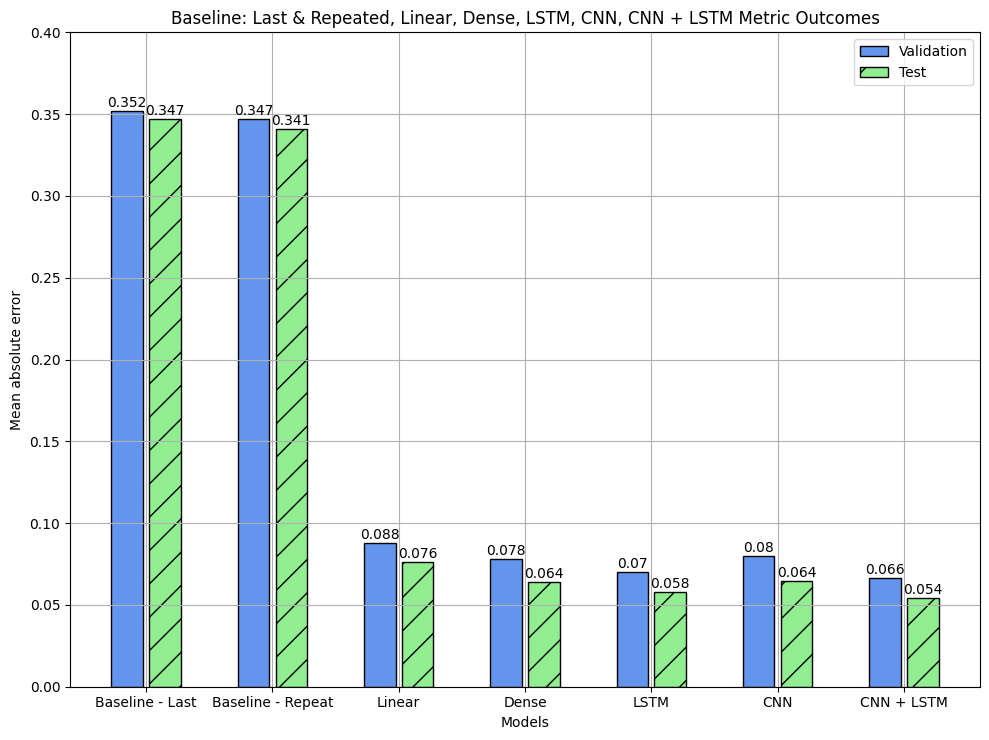

In [27]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(7)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='cornflowerblue', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='lightgreen', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.title('Baseline: Last & Repeated, Linear, Dense, LSTM, CNN, CNN + LSTM Metric Outcomes')
plt.tight_layout()
plt.show()

#### Convolutional Neural Network as Multi-Output Model

In [36]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

In [37]:
# Values from chapter 15

mo_mae_val = [0.048, 0.039, 0.023, 0.020]
mo_mae_test = [0.047, 0.036, 0.020, 0.017]

In [38]:
# Wide Multi-Step Convolutional Window
wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

In [39]:
# Multi-Output Model Set-Up
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

# Model Training
history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 0s 889us/step - loss: 0.0299 - mean_absolute_error: 0.0922 - val_loss: 0.0038 - val_mean_absolute_error: 0.0398
Epoch 2/50
384/384 [==============================] - 0s 782us/step - loss: 0.0031 - mean_absolute_error: 0.0358 - val_loss: 0.0023 - val_mean_absolute_error: 0.0320
Epoch 3/50
384/384 [==============================] - 0s 796us/step - loss: 0.0022 - mean_absolute_error: 0.0299 - val_loss: 0.0018 - val_mean_absolute_error: 0.0282
Epoch 4/50
384/384 [==============================] - 0s 862us/step - loss: 0.0019 - mean_absolute_error: 0.0273 - val_loss: 0.0015 - val_mean_absolute_error: 0.0261
Epoch 5/50
384/384 [==============================] - 0s 791us/step - loss: 0.0017 - mean_absolute_error: 0.0261 - val_loss: 0.0015 - val_mean_absolute_error: 0.0276
Epoch 6/50
384/384 [==============================] - 0s 858us/step - loss: 0.0016 - mean_absolute_error: 0.0252 - val_loss: 0.0013 - val_mean_absolute_error: 0.0240
Epoc

##### Combining Multi-Output CNN with LSTM

In [41]:
# Multi-Output with LSTM Model Set-Up
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    # Replacing the dense layer with LSTM
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

# Model Training
history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 2s 3ms/step - loss: 0.0254 - mean_absolute_error: 0.0968 - val_loss: 0.0040 - val_mean_absolute_error: 0.0430
Epoch 2/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0033 - mean_absolute_error: 0.0380 - val_loss: 0.0025 - val_mean_absolute_error: 0.0336
Epoch 3/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0336 - val_loss: 0.0021 - val_mean_absolute_error: 0.0313
Epoch 4/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0023 - mean_absolute_error: 0.0313 - val_loss: 0.0019 - val_mean_absolute_error: 0.0299
Epoch 5/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0293 - val_loss: 0.0016 - val_mean_absolute_error: 0.0268
Epoch 6/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0019 - mean_absolute_error: 0.0276 - val_loss: 0.0020 - val_mean_absolute_error: 0.0308
Epoch 7/50
384/3

##### Checking & Contrasting Model Metric Outcomes

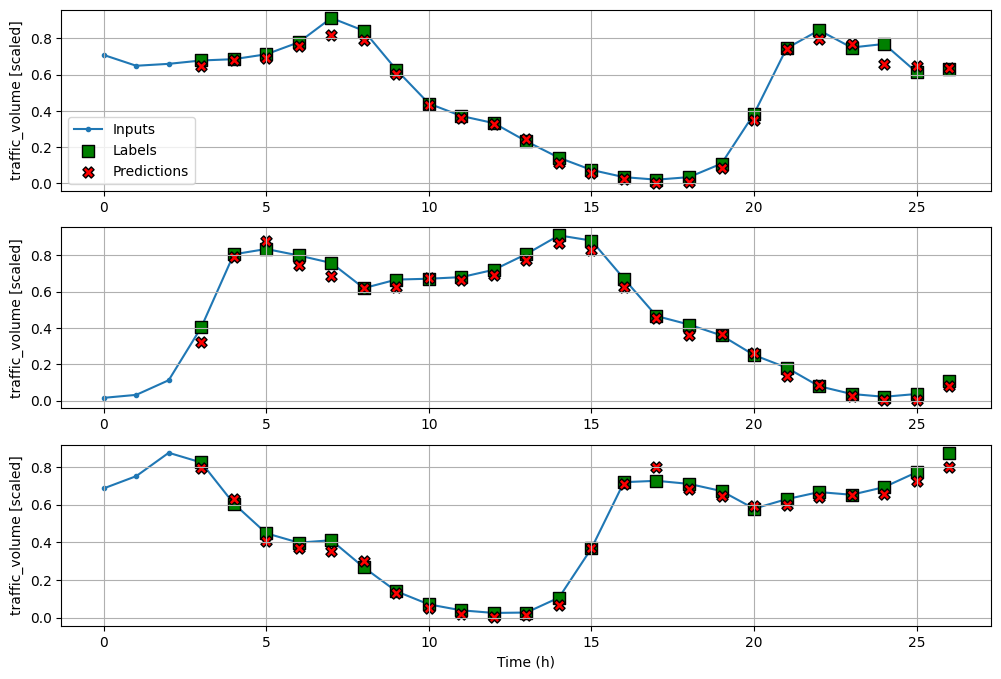

In [42]:
wide_mo_conv_window.plot(mo_cnn_lstm_model)

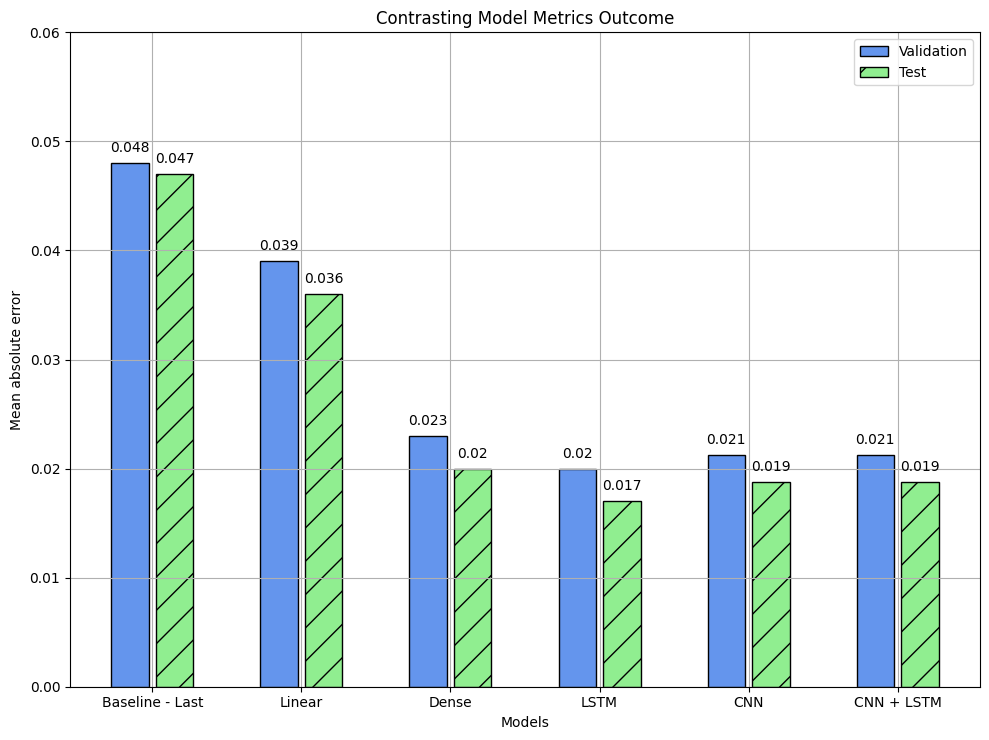

In [43]:
mo_mae_val.extend([v[1] for v in mo_val_performance.values()])
mo_mae_test.extend([v[1] for v in mo_performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='cornflowerblue', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='lightgreen', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.title('Contrasting Model Metrics Outcome')
plt.tight_layout()
plt.show()